# Investigating the Correlation Between SAT Score and Yale Matriculants
#### Ivan Adrian Nicole Tanvi

## 1.Intro 
### Research Question

- **Can we quantify the chance of a candidate’s admittance to Yale based on their average verbal, math, and SAT scores?**

### Dataset Description

The dataset being used for this research provides insight into the admissions statistics for Yale College from the years 1986 to 2022. 
The variables in the dataset that will be leveraged to answer the research question include:

- **Year Entered**: The year in which the applicant entered.
- **Number of Applicants**: The total number of individuals who applied.
- **Admit Rate**: The percentage of applicants who were granted admission.
- **Matriculant Yield**: The proportion of admitted students who chose to enroll.
- **Percentile for Verbal and Math Score**: These scores will provide a quantitative measure of the applicant's proficiency in English and mathematical skills.

The main focus of the research will be on the average verbal, math, and overall SAT scores of the applicants to determine their correlation with the admit rate.

## 2. Preliminary exploratory data analysis:

### 2.1 Importing Libraries

In [1]:
# import libraries 
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
install.packages("kknn")


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

### 2.2 Cleaning and Wrangling Data

In [2]:
# loading data 

yale_data <-  read_csv("https://raw.githubusercontent.com/ikkit1314/yale_admit/main/YaleAdmits.csv")
yale_data <- yale_data |> 
    mutate(
        Avg_SAT_Score = (SAT10 + SAT25 + SAT50 + SAT75 + SAT90) / 5,
        Avg_Math_Score = (Math10th + Math25th + Math50th + Math75th + Math90th) / 5,
        Avg_Verbal_Score = (Verbal10th + Verbal25th + Verbal50th + Verbal75th + Verbal90th) / 5) |> 
    select(YearEntered = `Year Entered`, "Avg_Math_Score", "Avg_SAT_Score", "Avg_Verbal_Score", "AdmitRate")
yale_data

Rows: 37 Columns: 31
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): VerbalScore, MathScore
dbl (29): Year Entered, Applications, Admits, AdmitRate, Matriculant, Yield,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


YearEntered,Avg_Math_Score,Avg_SAT_Score,Avg_Verbal_Score,AdmitRate
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1986,692,1350,658,0.181
1987,692,1346,654,0.177
1988,694,1348,654,0.185
1989,696,1348,652,0.188
1990,702,1358,656,0.197
1991,702,1358,656,0.220
1992,692,1340,648,0.222
1993,698,1348,650,0.229
1994,706,1364,658,0.189


#### 2.2.1 Visualizing The Relationship

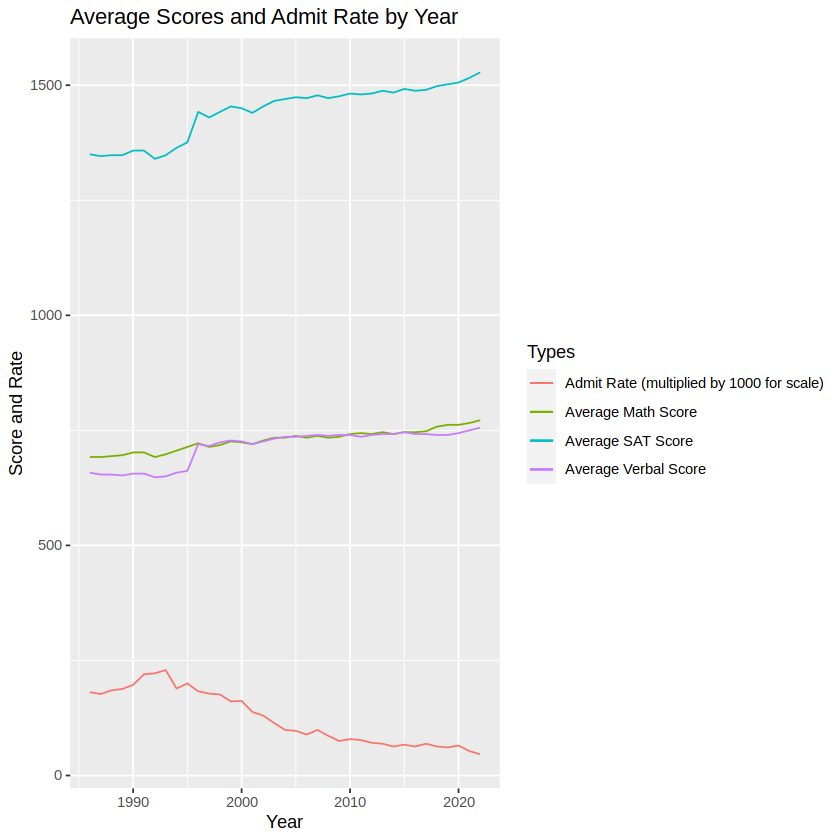

In [3]:
yale_plot <- ggplot(yale_data, aes(x = YearEntered)) +
    geom_line(aes(y = Avg_SAT_Score, color = "Average SAT Score")) +
    geom_line(aes(y = Avg_Math_Score, color = "Average Math Score")) +
    geom_line(aes(y = Avg_Verbal_Score, color = "Average Verbal Score")) +
    geom_line(aes(y = AdmitRate*1000, color = "Admit Rate (multiplied by 1000 for scale)"))+ 
    labs(title = "Average Scores and Admit Rate by Year",
         x = "Year",
         y = "Score and Rate",
         color = "Types")
yale_plot

### 2.3 Splitting Data into Training and Testing

In [4]:
set.seed(1314)
yale_split <- initial_split(yale_data , prop=0.75)
yale_train <- training(yale_split)
yale_test <- testing(yale_split)

#### 2.3.1 Visualizing Training data

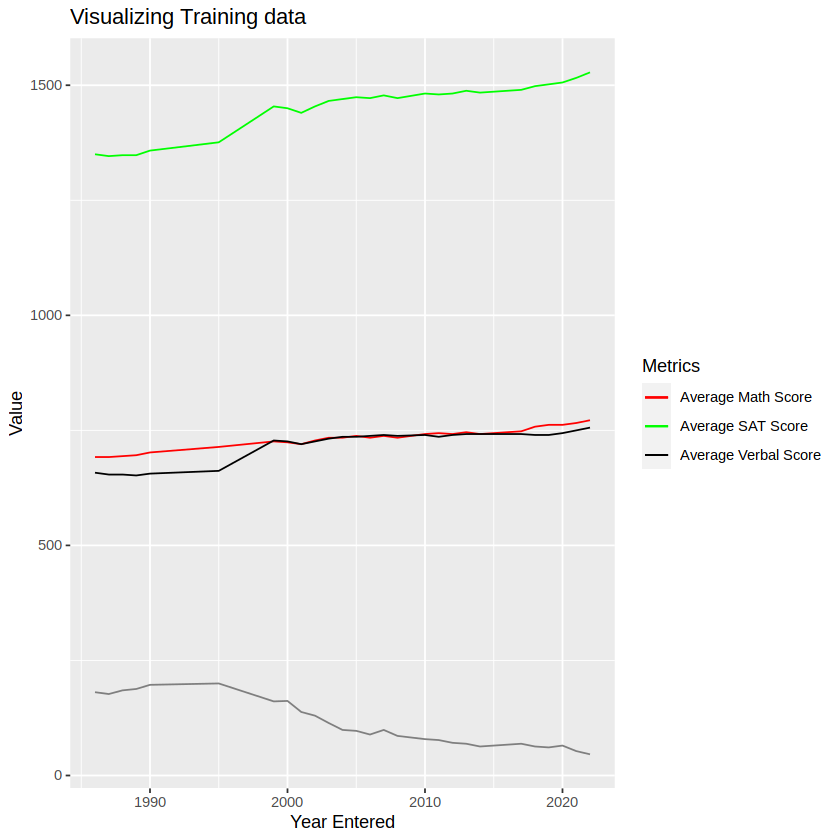

In [5]:
yale_train_plot <- ggplot(yale_train, aes(x = YearEntered)) + 
    geom_line(aes(y = AdmitRate * 1000, color = "Admit Rate Admit Rate (multiplied by 1000 for scale)")) + 
    geom_line(aes(y = Avg_Math_Score, color = "Average Math Score")) + 
    geom_line(aes(y = Avg_SAT_Score, color = "Average SAT Score")) +
    geom_line(aes(y = Avg_Verbal_Score, color = "Average Verbal Score")) +
    labs(title = "Visualizing Training data", x = 'Year Entered', y = 'Value', color = "Metrics") +
    scale_color_manual(values = c("Admit Rate" = "blue", "Average Math Score" = "red", 
                                  "Average SAT Score" = "green", "Average Verbal Score" = "black"))
yale_train_plot

### 2.4 Making Recipe and Scaling Data

In [6]:
yale_recipe <- recipe(AdmitRate ~ Avg_SAT_Score + Avg_Math_Score + Avg_Verbal_Score, data = yale_train) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

### 2.5 kNN Specification and Fold Cross-Validation 

In [7]:
yale_spec <- nearest_neighbor(weight_func = "rectangular",neighbors = tune()) |>
    set_engine("kknn")  |>
    set_mode("regression")

yale_vfold <- vfold_cv(yale_train, v = 10, strata = AdmitRate)

Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
• Stratification will use 1 breaks instead.”
Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”


### 2.6 Finding Best k using Cross-Validation

In [ ]:
gridvals <- tibble(neighbors = seq(1,20))

yale_results <- workflow()  |>
    add_recipe(yale_recipe)  |>
    add_model(yale_spec)  |>
    tune_grid(resamples = yale_vfold, grid = gridvals)  |>
    collect_metrics()

best_k <- yale_results |>
    filter(.metric == "rmse")|>
    slice_min(mean, n=1)|>
    pull(neighbors)
## best k was 3

best_k <- 3
best_k

! Fold01: preprocessor 1/1, model 1/1: 20 samples were requested but there were 24 rows in the data. 19 will be...

! Fold02: preprocessor 1/1, model 1/1: 20 samples were requested but there were 24 rows in the data. 19 will be...

! Fold02: internal:
  There were 3 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(truth = Admit...
    na_rm = na_rm)`.
  ℹ In group 17: `neighbors = 17`.
  Caused by warning:
  ! A correlation computation is required, but `estimate` is c...
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 2 r...

! Fold03: preprocessor 1/1, model 1/1: 20 samples were requested but there were 24 rows in the data. 19 will be...

! Fold04: preprocessor 1/1, model 1/1: 20 samples were requested but there were 24 rows in the data. 19 will be...

! Fold05: preprocessor 1/1, model 1/1: 20 samples were requested but there were 24 rows in the data. 19 will be...



### 2.7 Fitting the Model with Best k and Visualize

In [9]:
 final_yale_spec <- nearest_neighbor(weight_func = "rectangular" , neighbors = best_k)|>
                set_engine("kknn") |>
                set_mode("regression")

final_yale_fit <- workflow() |>
    add_recipe(yale_recipe) |>
    add_model(final_yale_spec) |>
    fit(data = yale_train)

final_yale_result <- final_yale_fit |>
                    predict(yale_test) |>
                    bind_cols(yale_test)
final_yale_result

.pred,YearEntered,Avg_Math_Score,Avg_SAT_Score,Avg_Verbal_Score,AdmitRate
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.197,1991,702,1358,656,0.220
0.177,1992,692,1340,648,0.222
0.188,1993,698,1348,650,0.229
0.197,1994,706,1364,658,0.189
0.138,1996,722,1442,720,0.183
0.138,1997,714,1430,716,0.178
0.138,1998,718,1442,724,0.176
0.099,2009,736,1476,740,0.075
0.069,2015,746,1492,746,0.067


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


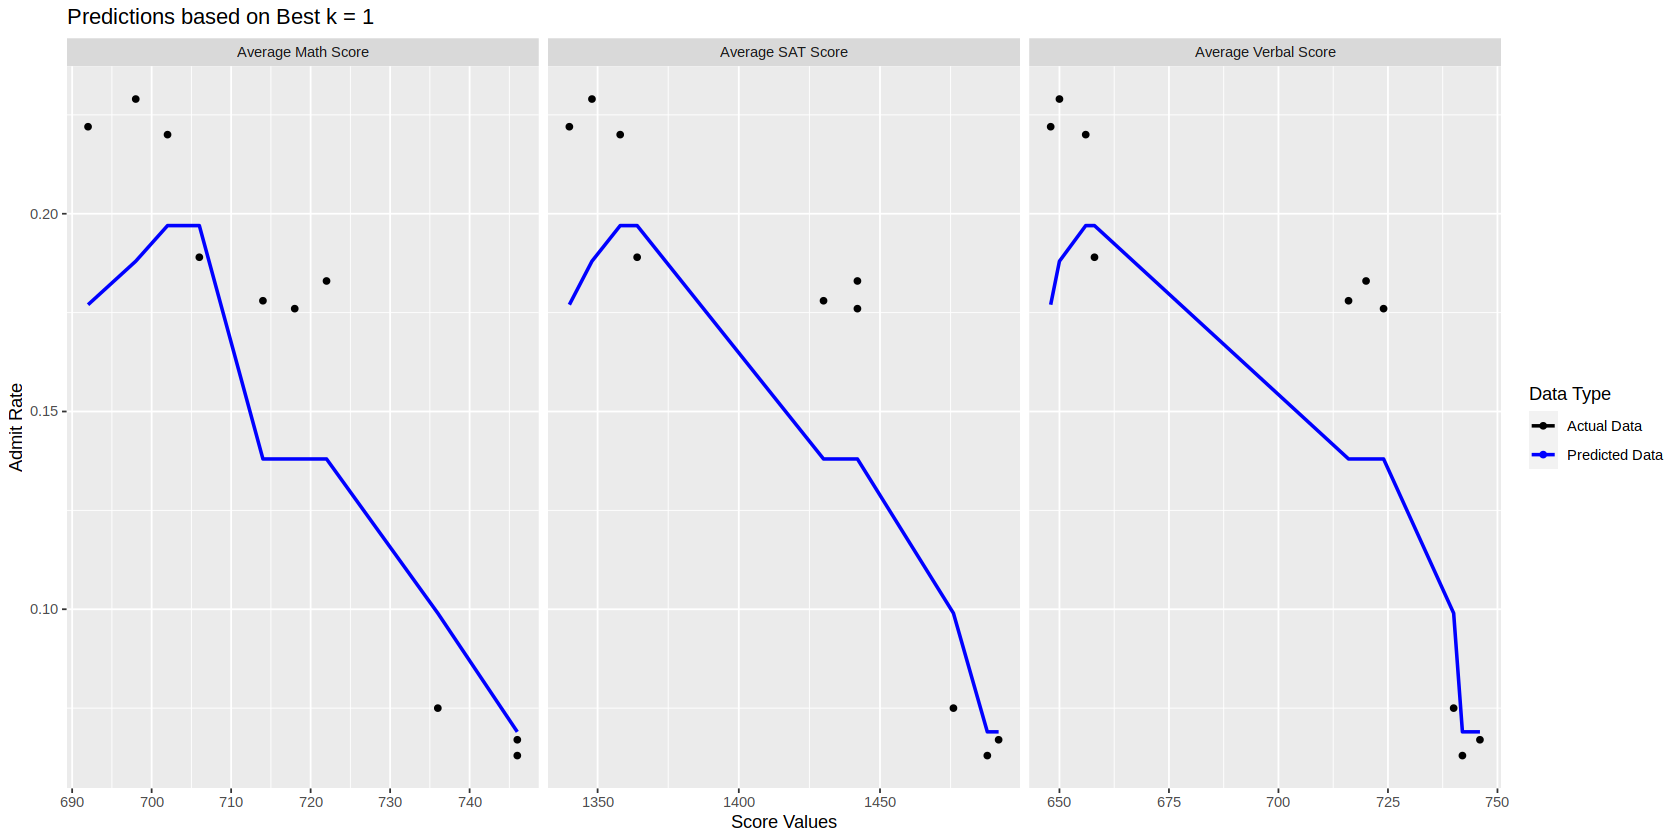

In [10]:
facet_titles <- c(
  Avg_SAT_Score = "Average SAT Score",
  Avg_Math_Score = "Average Math Score",
  Avg_Verbal_Score = "Average Verbal Score"
)

options(repr.plot.width = 14, repr.plot.height = 7)
yale_long <- final_yale_result |>
  pivot_longer(cols = c(Avg_SAT_Score, Avg_Math_Score, Avg_Verbal_Score), 
               names_to = "Score_Type", 
               values_to = "Score_Value")

yale_k_plot <- ggplot(yale_long, aes(x = Score_Value, y = AdmitRate)) +
             geom_point(aes(color = "Actual Data")) +
            xlab("Score Values")+
             ylab("Admit Rate") +
             geom_line(aes(y = .pred, color = "Predicted Data"), size = 1) +
             facet_grid(~ Score_Type, scales = "free_x",labeller = labeller(Score_Type = facet_titles)) +
             ggtitle(paste0("Predictions based on Best k = ", best_k)) +
             scale_color_manual(values = c("Actual Data" = "black", "Predicted Data" = "blue"), 
                                name = "Data Type")


yale_k_plot


### 2.8 Predict with Given Value

In [11]:
new_observation <- tibble(
  Avg_Math_Score = 700,  
  Avg_SAT_Score = 1400,  
  Avg_Verbal_Score = 700)

predicted_admit_rate <- final_yale_fit |>
  predict(new_observation) |>
  pull(.pred) %>%
  {. * 100} |>
  round(2)

predicted_admit_rate

[1] 13.8

### 2.9 Convert to a result

In [12]:
admit_percentage <- 10

if (predicted_admit_rate > admit_percentage) {
  predicted_admission_status <- "Admitted"
} else {
  predicted_admission_status <- "Not Admitted"}
predicted_admission_status

[1] "Admitted"

## 3. Method

#### 1. Importing Libraries:
The code starts by importing necessary libraries such as `tidyverse`, `tidymodels`, `dplyr`, and `kknn`.

#### 2. Cleaning and Wrangling Data:
- The dataset "YaleAdmits.csv" is loaded into the `yale_data` variable.
- New columns are created for average SAT, Math, and Verbal scores by taking the mean of the 10th, 25th, 50th, 75th, and 90th percentiles for each of them.
- Only selected columns: Year Entered, Average Math Score, Average SAT Score, Average Verbal Score, and Admit Rate.

#### 3. Visualizing The Relationship:
A line plot is created to visualize the relationship between the year of entry and the average scores (SAT, Math, Verbal) and admit rate.

#### 4. Splitting Data into Training and Testing:
The dataset is split into training (75%) and testing (25%) sets.

#### 5. Visualizing Training Data:
A line plot is created to visualize the admit rate and average scores (Math, SAT, Verbal) for the training data.

#### 6. Making Recipe and Scaling Data:
A recipe is created to center and scale the predictor variables.

#### 7. kNN Specification and Fold Cross-Validation:
The k-nearest neighbors model is specified, and use 10-fold cross-validation.

#### 8. Finding Best k using Cross-Validation:
The best value of k for the kNN  is determined by using the cross-validation. Based on the results, the best k values is 1 using cross-validation. However using k=1 can prone to overfitting. In order to to mitigate the risk of overfitting, we choose k = 3 to improve the model's ability to generalize to new data.

#### 9. Fitting the Model with Best k and Visualize:
The kNN model is fit using the best 'k' value from previous step.
Then use the result from the fit to visualize the prediction and the actual values

#### 10. Predict with Given Value:
The model is used to predict the admit rate for a new observation with given values for average Math, SAT, and Verbal scores. (The individual's score in this case)

#### 11. Convert to a Result:
Based on the predicted admit rate, a decision is made whether the observation would be "Admitted" or "Not Admitted".



## 4. Expected outcomes and significance


### What do you expect to find?
- There is a very strong relationship between Yale admittance and SAT scores; the higher the score, the more likely they will be admitted.
- Similarly, the lower the score, the less likely they will be admitted.
- Regardless of score, people are admitted based on outside variables that are not considered in the scope of this data science project.

### What impact could such findings have?
- Depending on the correlation between SAT score and admission rate, people under a certain score don’t have to bother applying to Yale because they know they will be rejected.
    - People that want to go to Yale can retake their SAT to get a better score if they fall under this threshold.
- Motivate students to achieve more academically.

### What future questions could this lead to?
- To what extent are the SAT scores considered for students of different backgrounds?
    - Does it “count less” for applicants that are unable to speak English?
    - To what extent do SAT scores influence the admittance of an applicant? (i.e., what is the weight of their score compared to their accomplishments?)
- Is there a point in which Yale will always deny a student based on their SAT score alone?
    - If so, is it because of their score or because a lower score generally correlates with low academic standing?
    - To a similar end, is there a point in which Yale will accept a student based on their SAT score alone?
- What separates a student that got in with a low SAT from a student that got in with a high SAT?
    - Across the span of their post-secondary education, which student tends to be more successful?
- Does Yale value math or English? Or do they look at the score as a whole?





## 5. Bibilography 

RYAN. (2023, October). Yale College Admissions 1986-2022, Version 1. Retrieved October 25, 2023 from https://www.kaggle.com/datasets/rcd1693/yale-admissions/data.